In [2]:
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import random
import scipy

In [3]:
gt_images_folder = "/project/trinity/datasets/apricot/pub/apricot-mask/data_mask_v2"
gt_images_names = os.listdir(gt_images_folder)

print(len(gt_images_names))

873


In [4]:
def compute_vectorized_iou(given_mask, masks):
    given_mask_expanded = np.expand_dims(given_mask, axis=0)
    masks_expanded = np.stack(masks)
    intersection = np.logical_and(masks_expanded > 0, given_mask_expanded > 0)
    union = np.logical_or(masks_expanded > 0, given_mask_expanded > 0)
    intersection_sum = np.sum(intersection, axis=(1, 2))
    union_sum = np.sum(union, axis=(1, 2))
    iou_values = intersection_sum / union_sum
    return iou_values

def getRandomImages(n=5):
    # random_numbers = random.sample(range(0, len(gt_images_names)-1), n)
    random_numbers = [242, 46, 812, 483, 381, 618, 107, 815, 443, 78, 25, 308]

    imgs = []
    img_masks = []
    for i in range(n):
        # idx = random.randint(0,len(gt_images_names)-1)
        img_info = torch.load(os.path.join(gt_images_folder, gt_images_names[random_numbers[i]]))
        img = np.squeeze(img_info['Image'])
        img = np.uint8(img * 255.0)
        img = cv2.resize(img, (512,512), interpolation = cv2.INTER_AREA)
        imgs.append(img)

        img_mask = np.squeeze(img_info['Mask'])
        img_mask = np.uint8(img_mask * 255.0)
        img_mask = cv2.resize(img_mask, (512,512), interpolation = cv2.INTER_AREA)
        img_masks.append(img_mask)

    return imgs, img_masks, random_numbers

In [5]:
sam = sam_model_registry["vit_h"](checkpoint="/project/trinity/pretrained_models/sam_facebook/sam_vit_h_4b8939.pth")
sam.to(device='cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

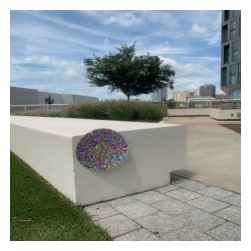

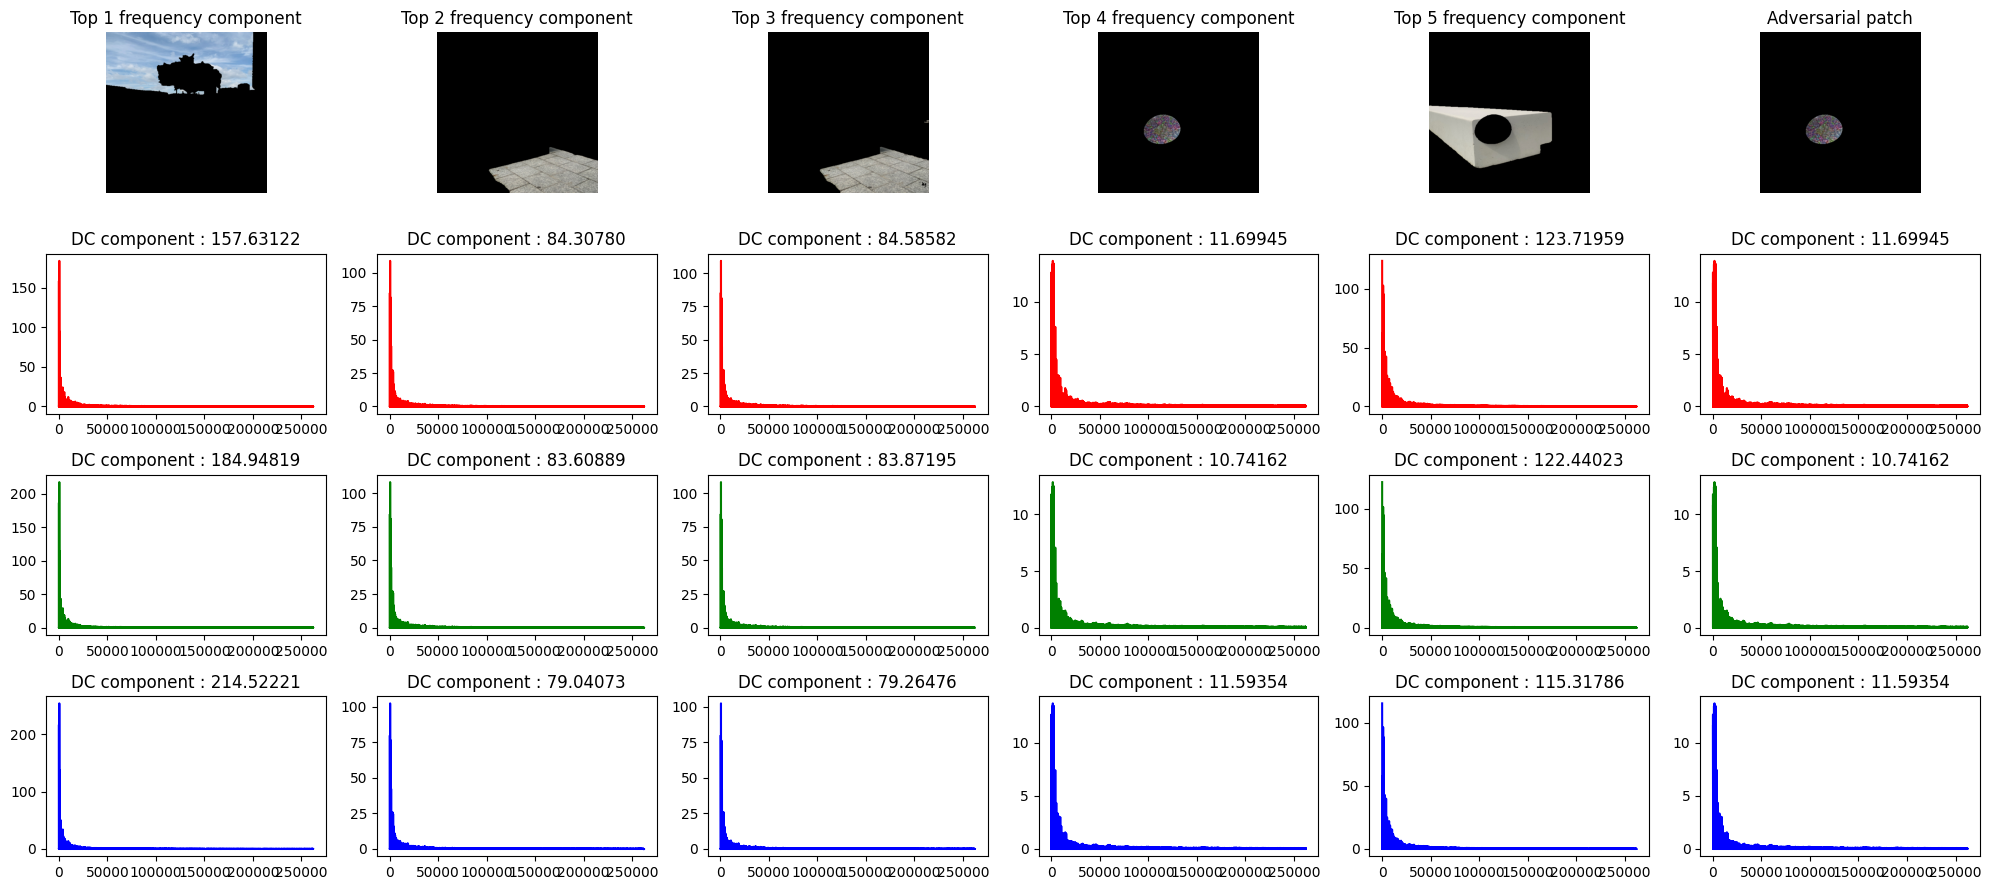

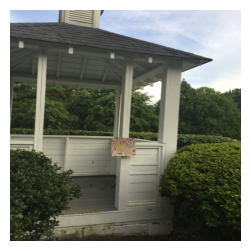

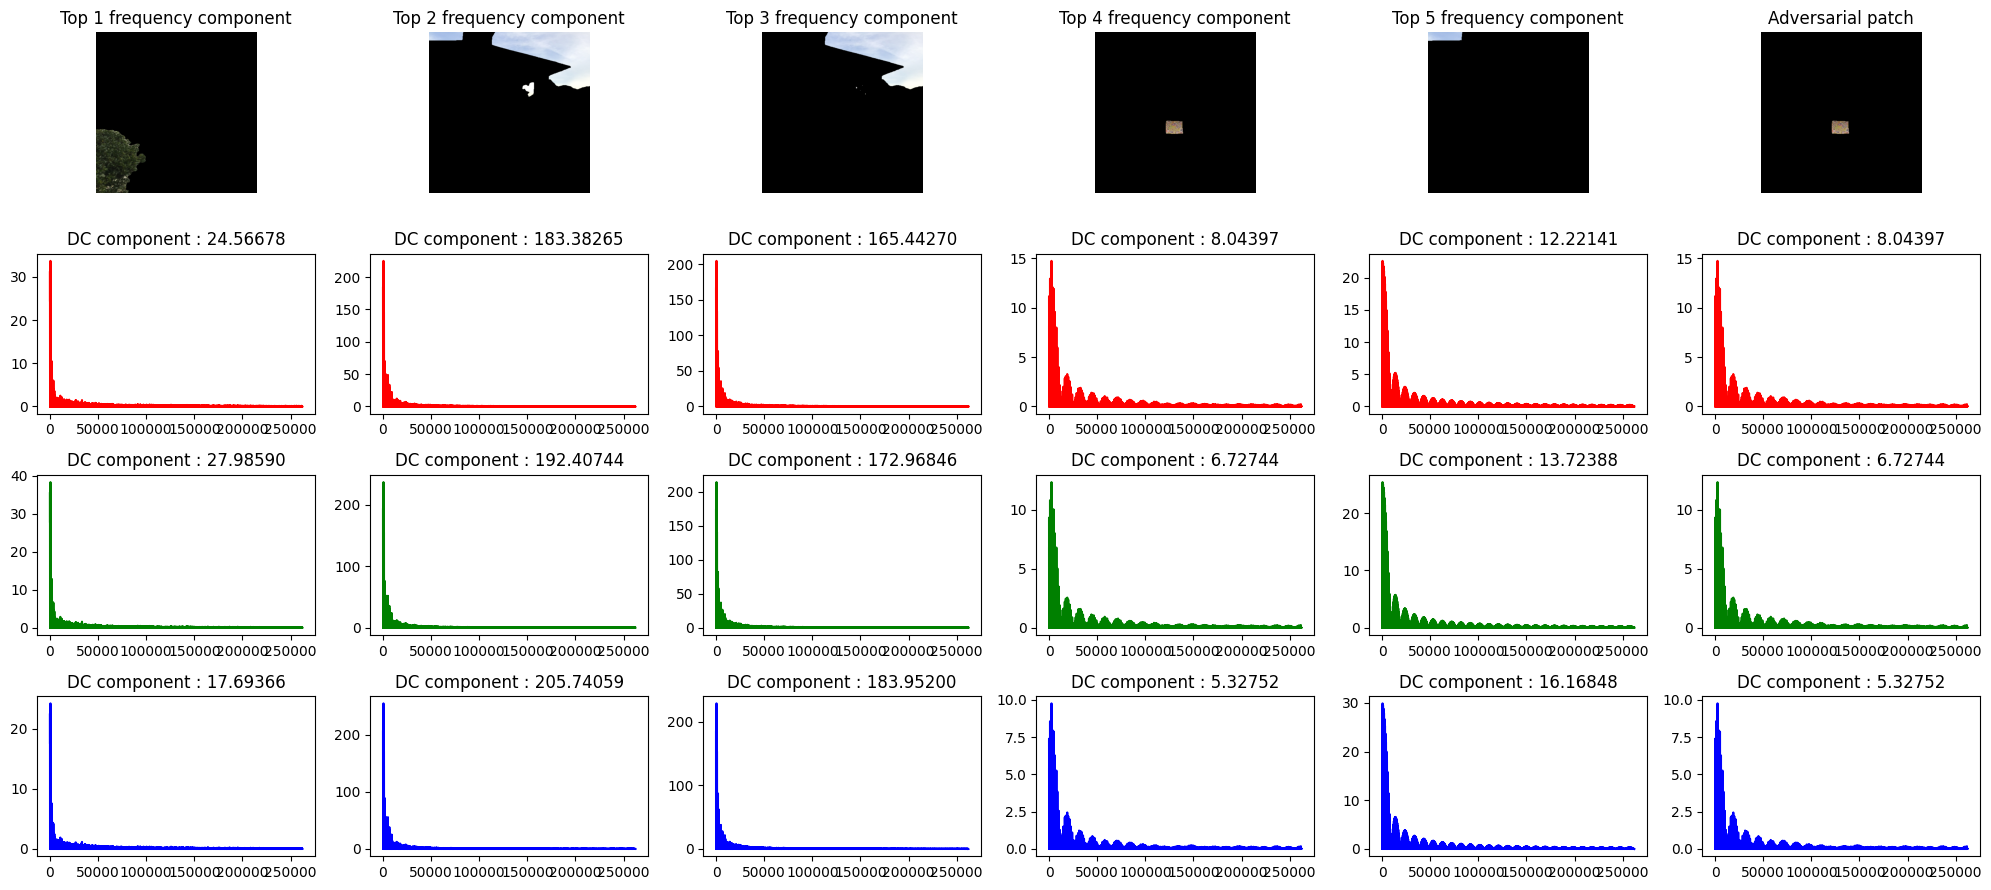

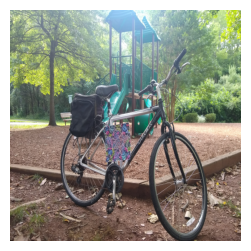

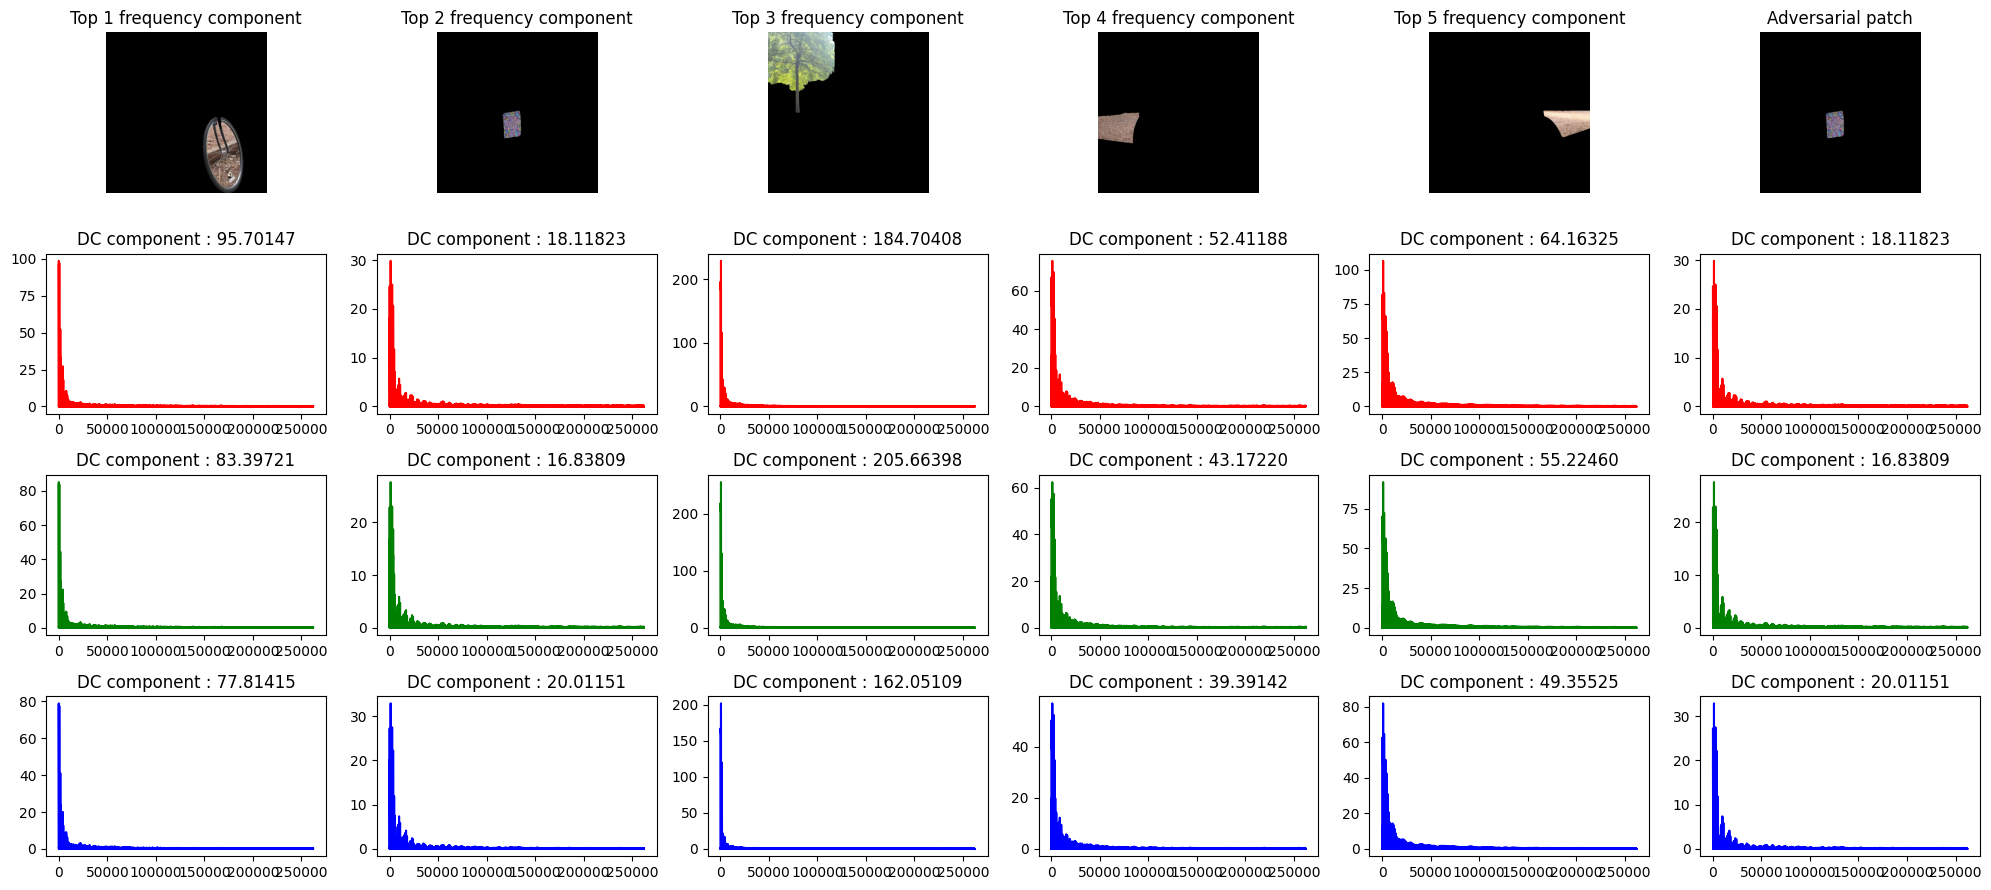

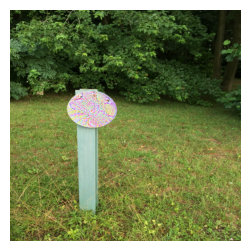

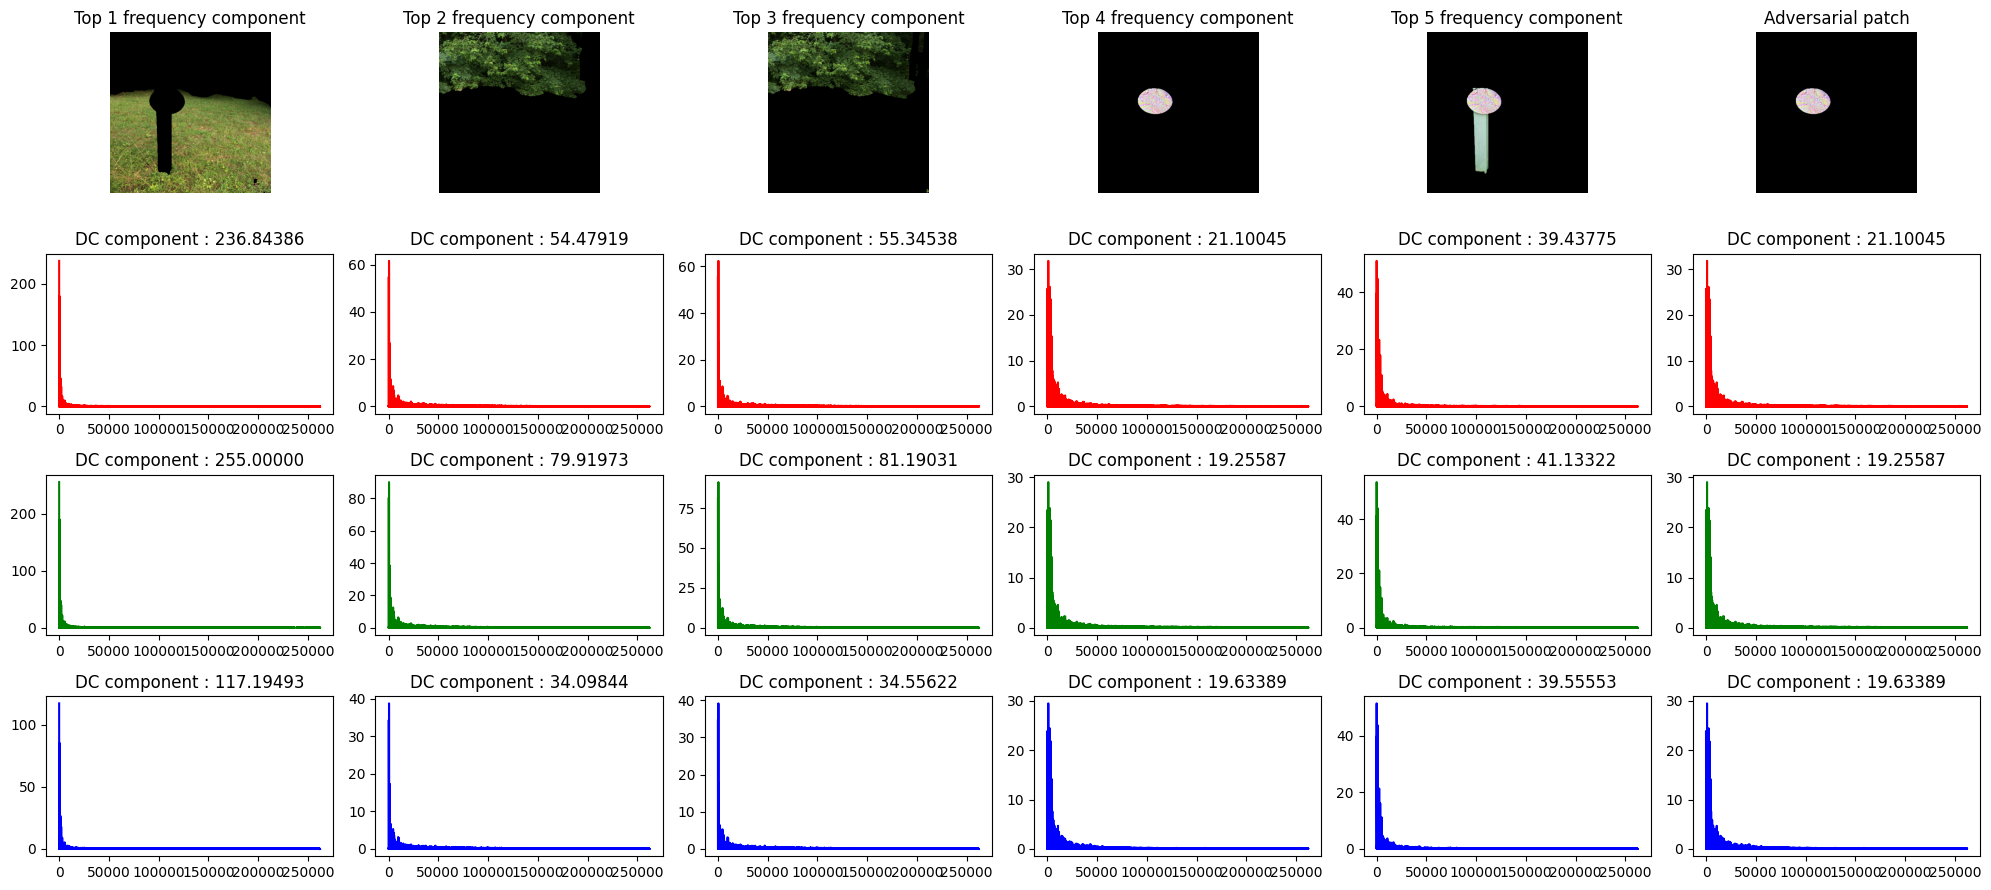

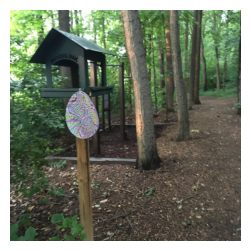

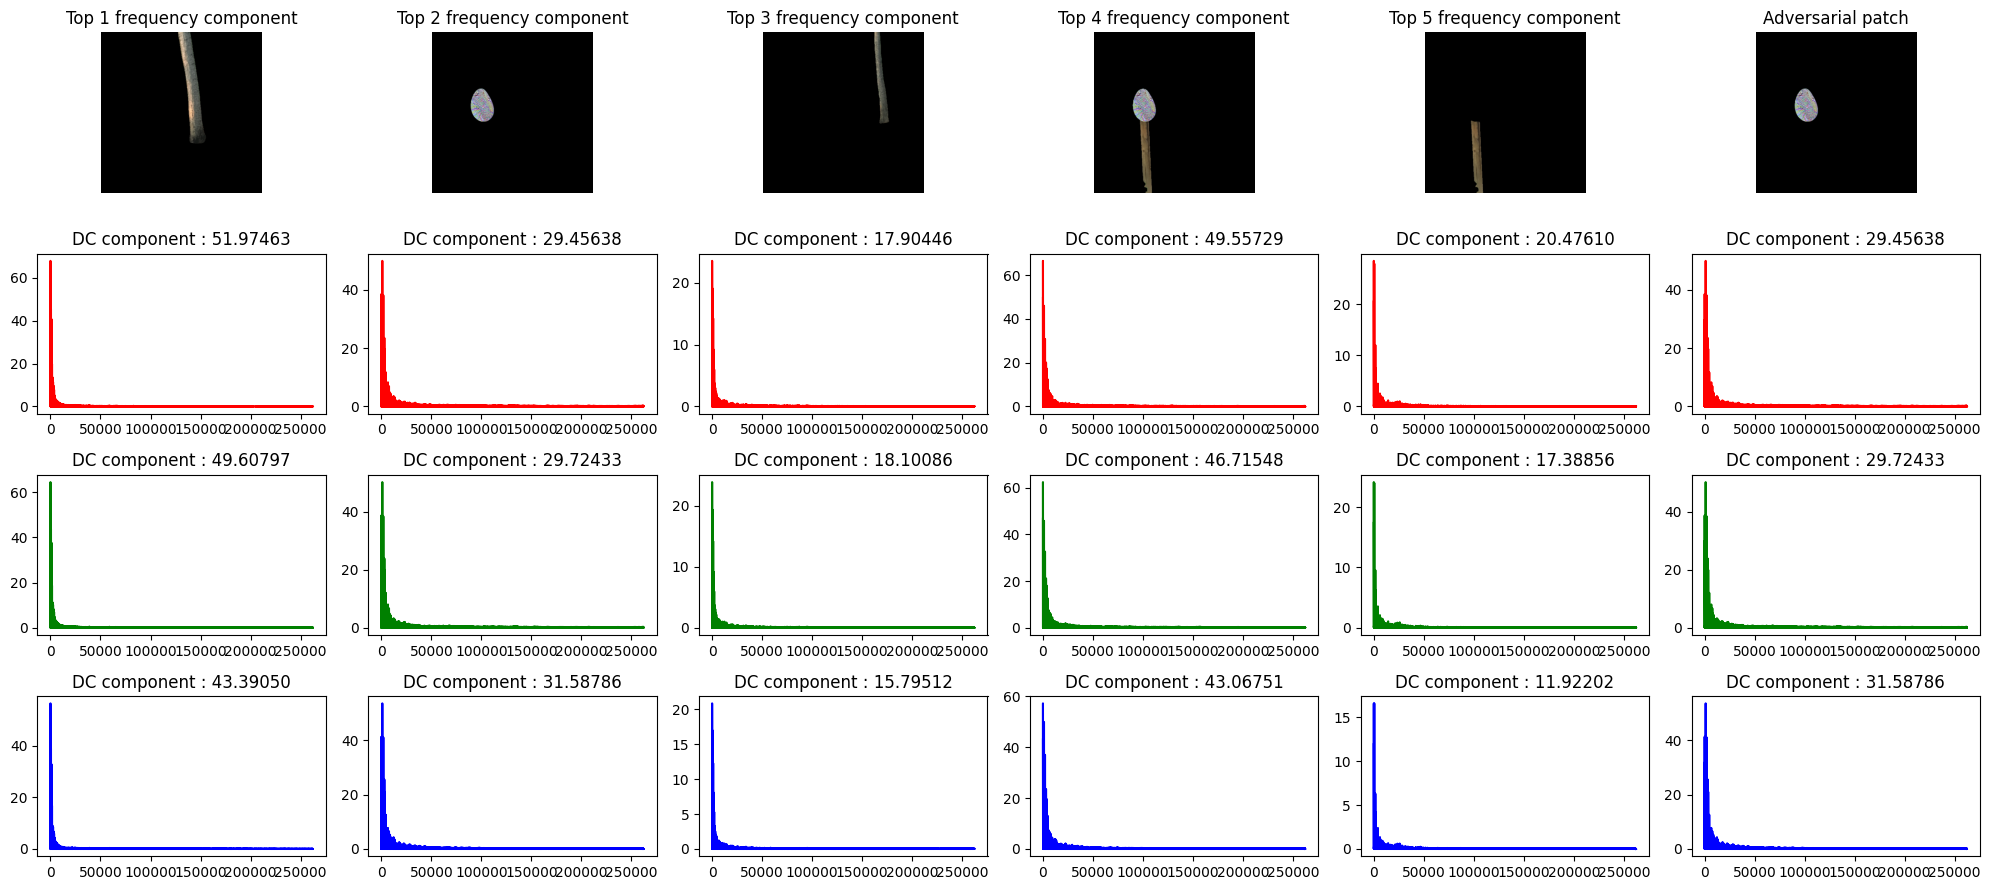

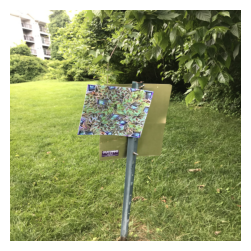

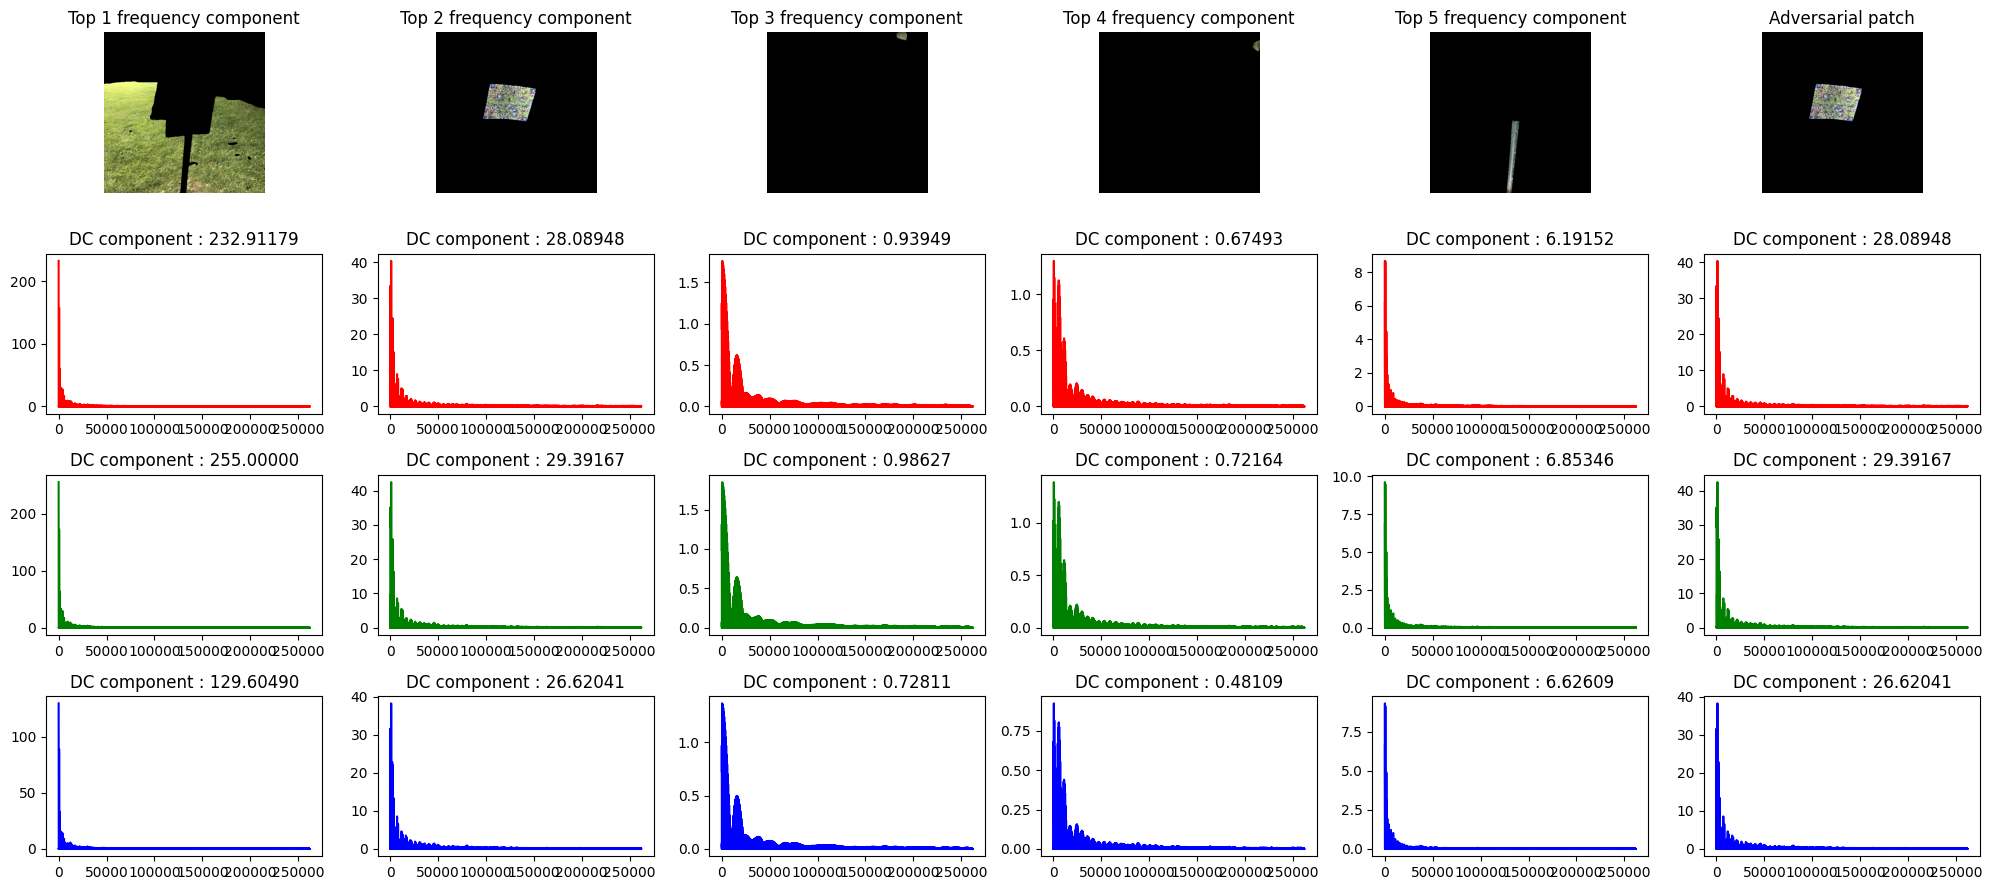

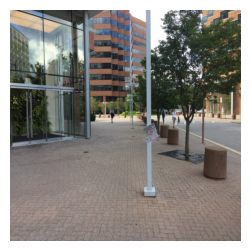

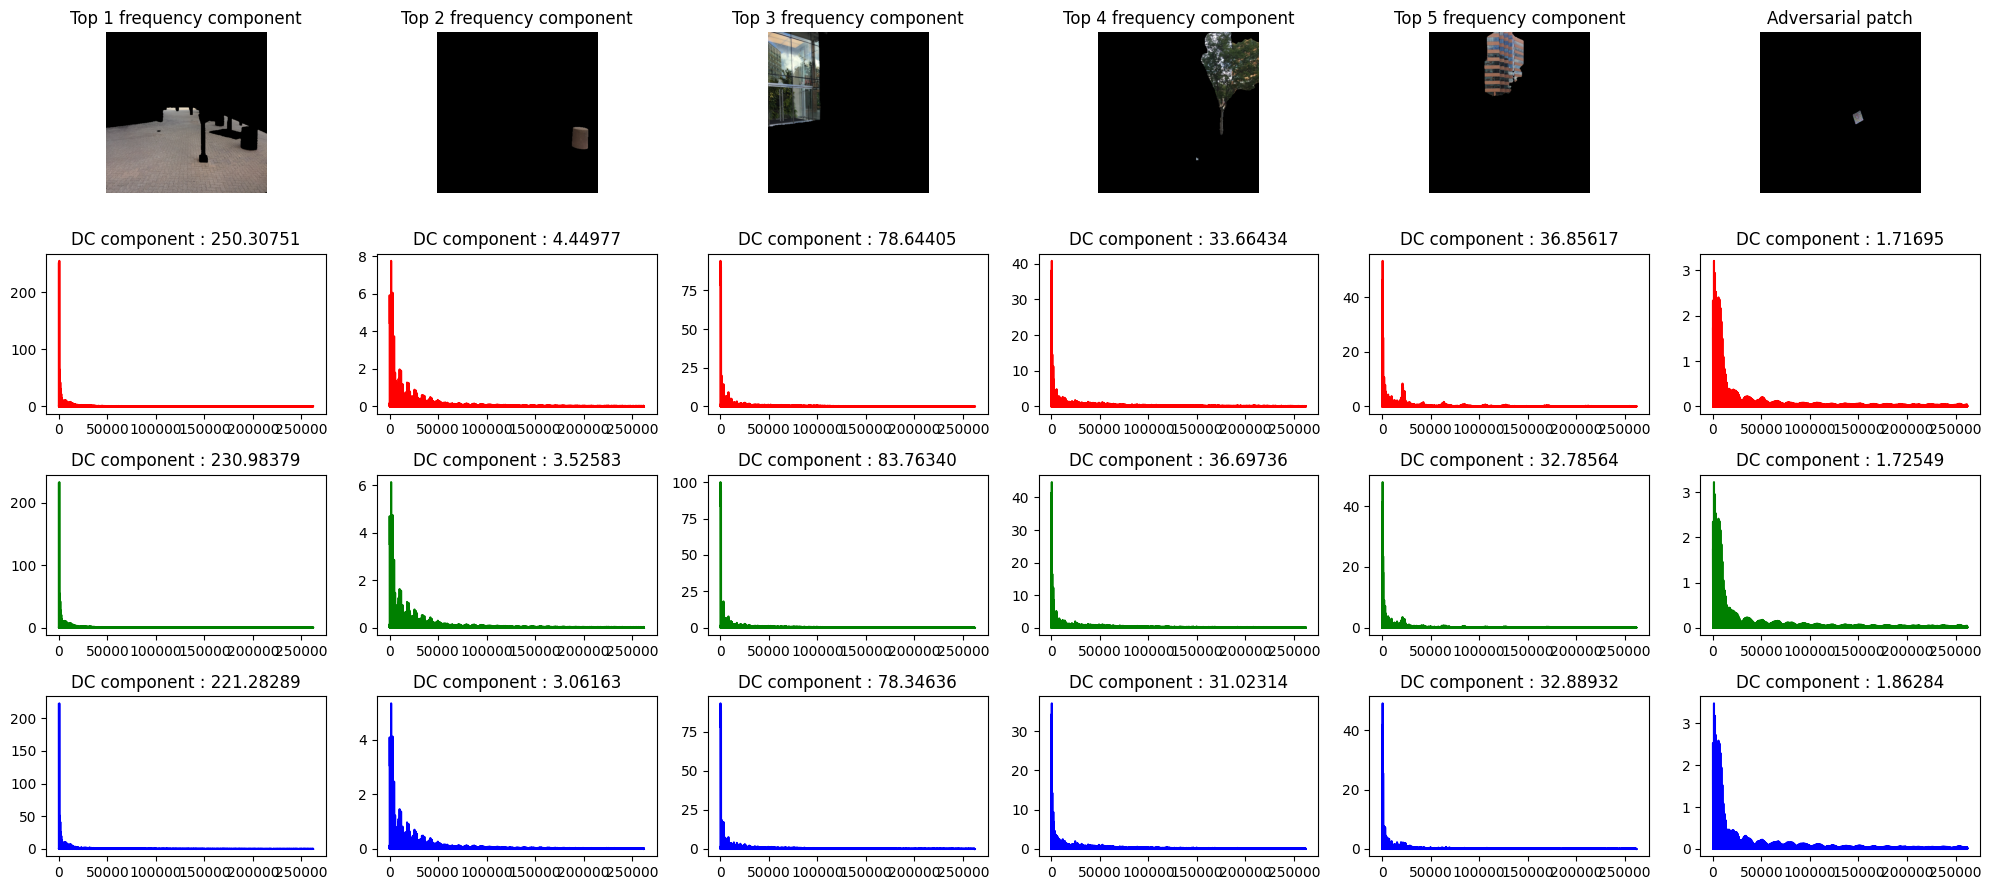

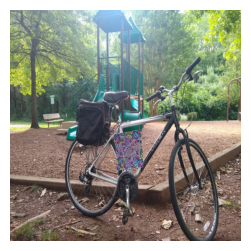

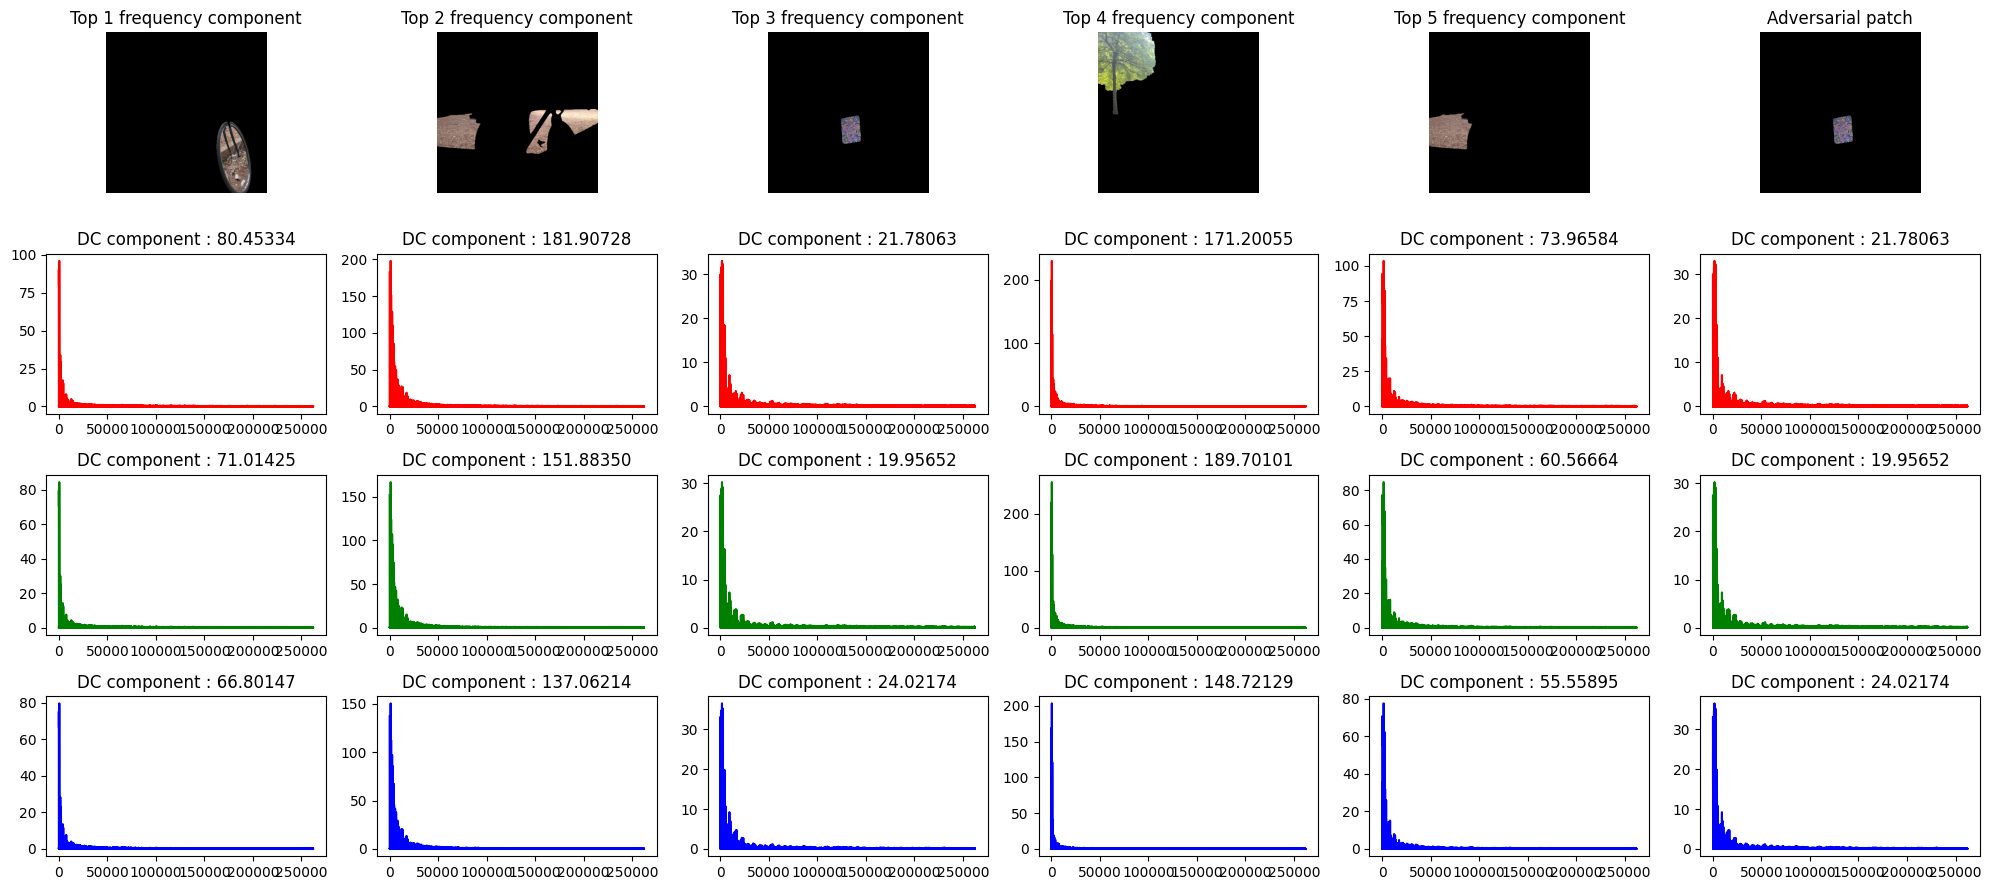

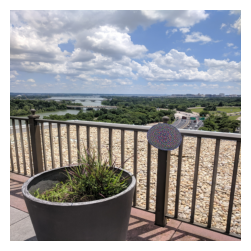

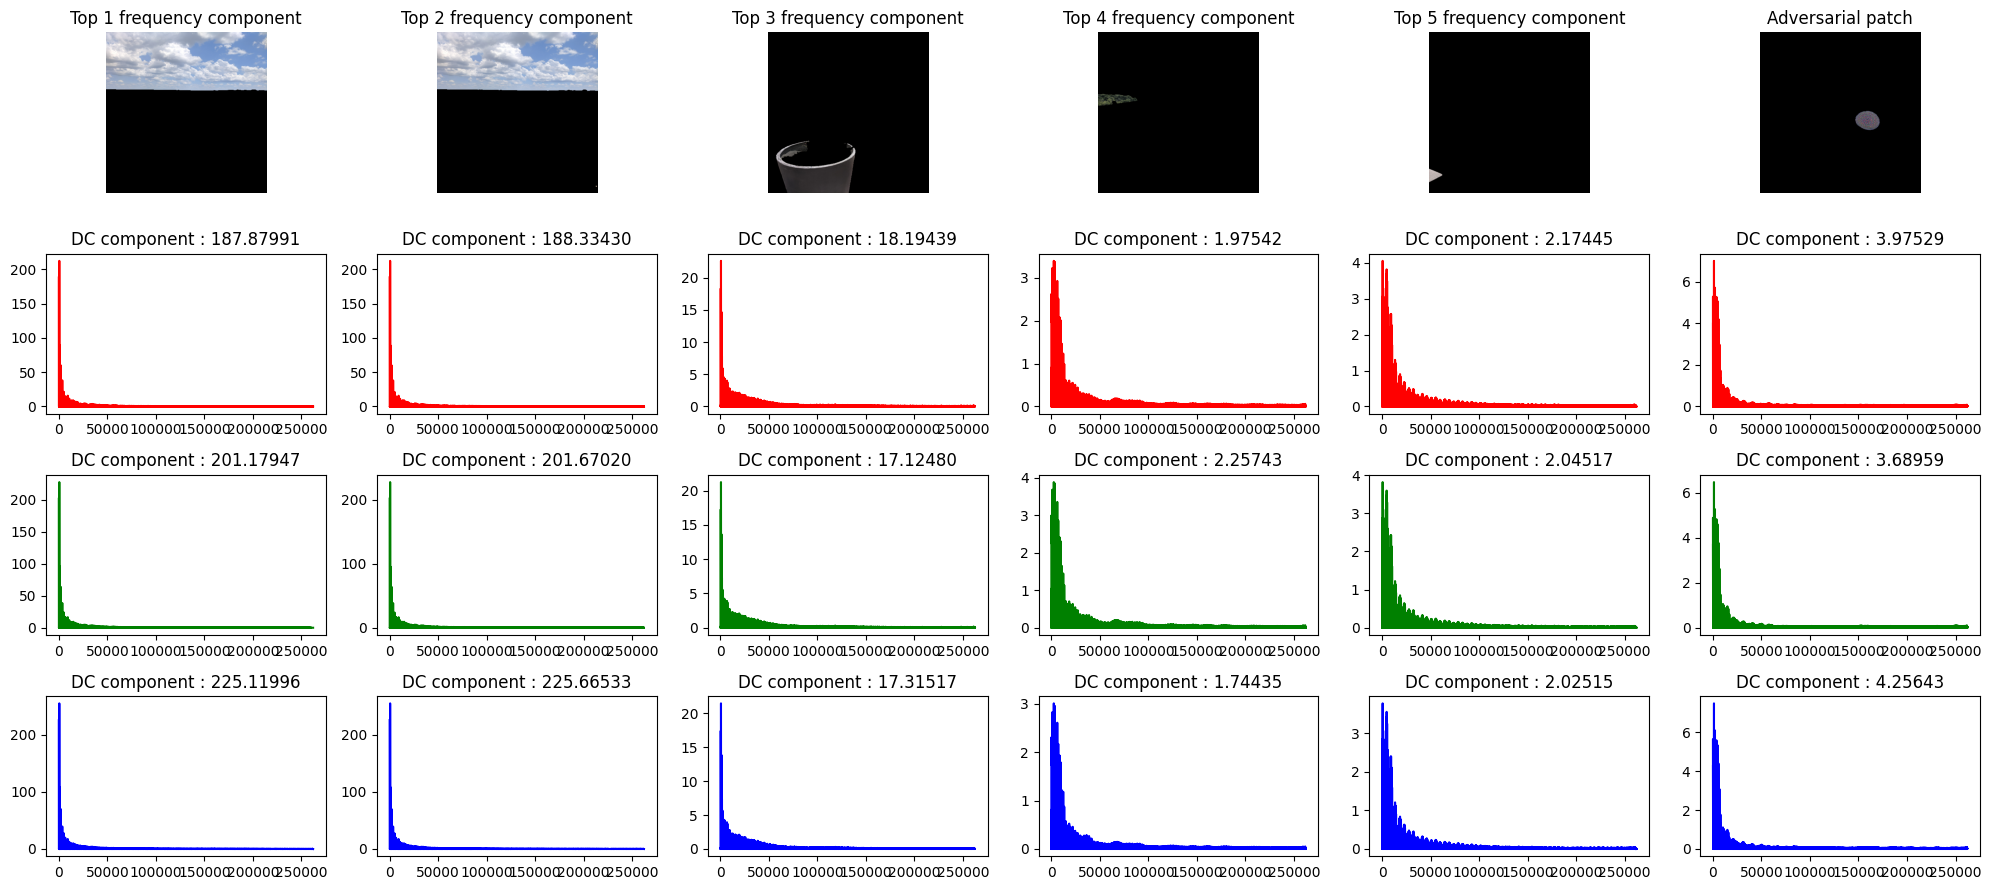

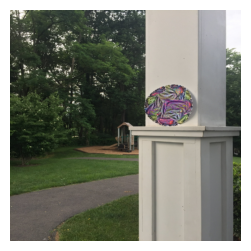

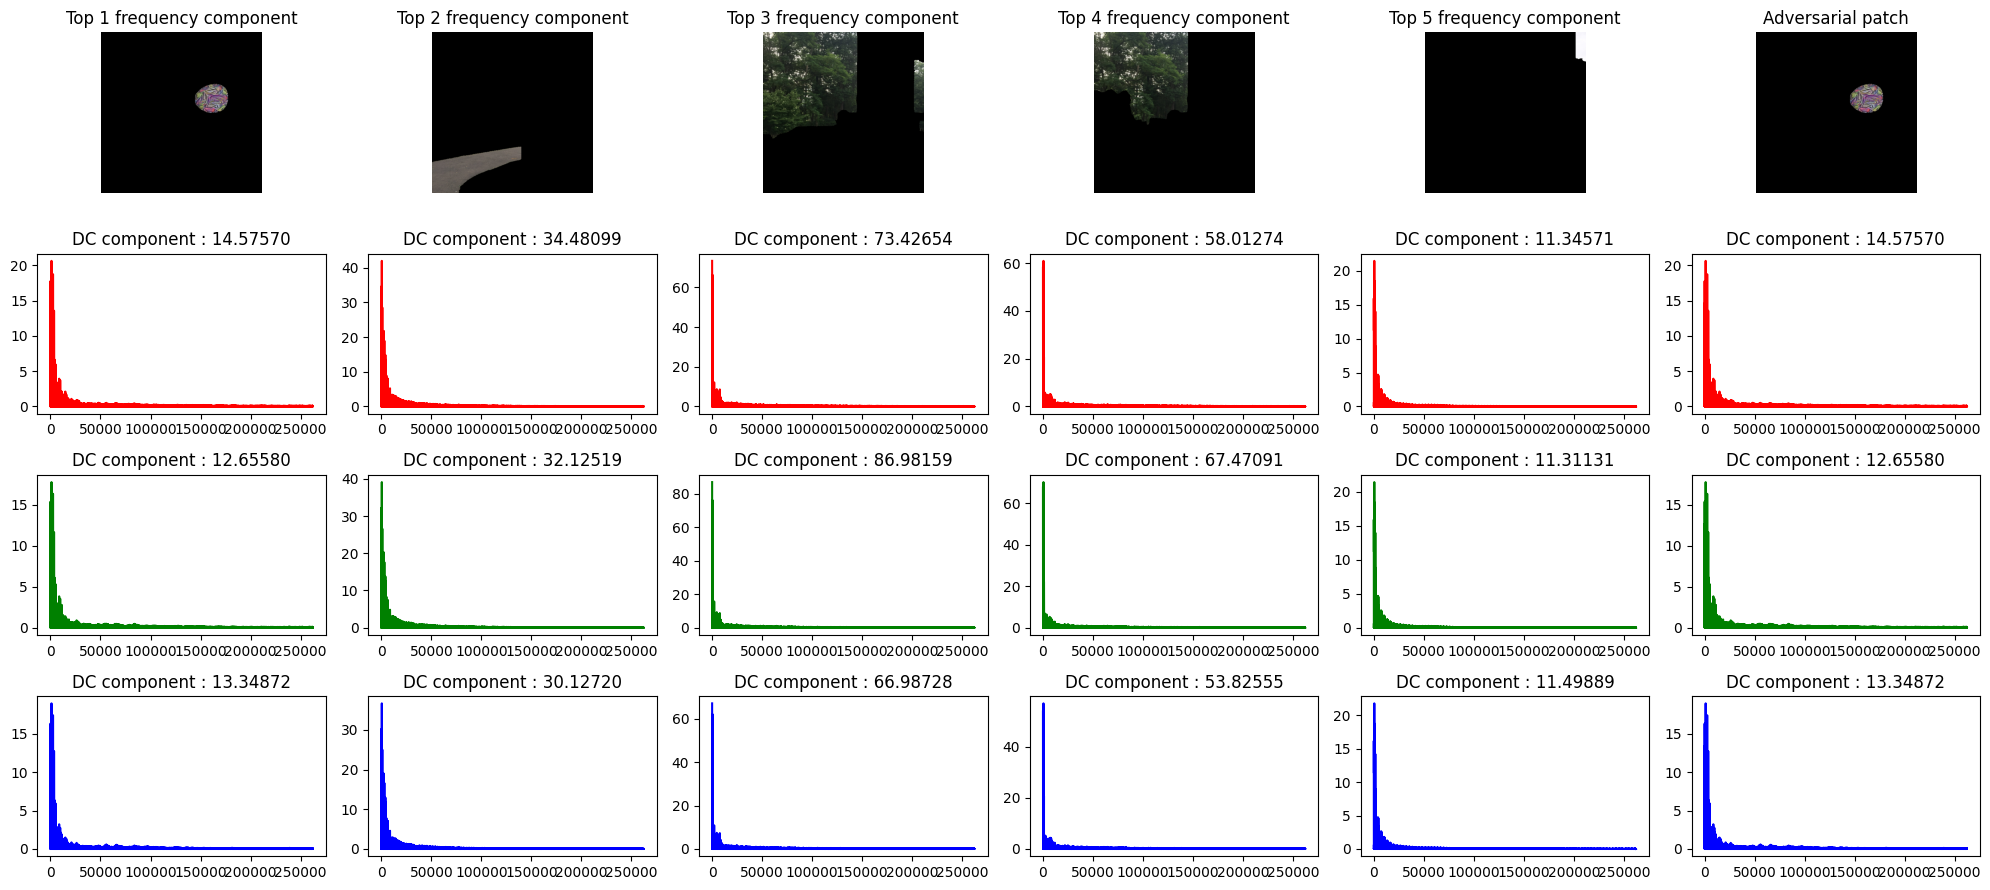

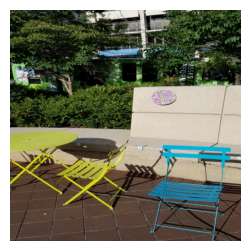

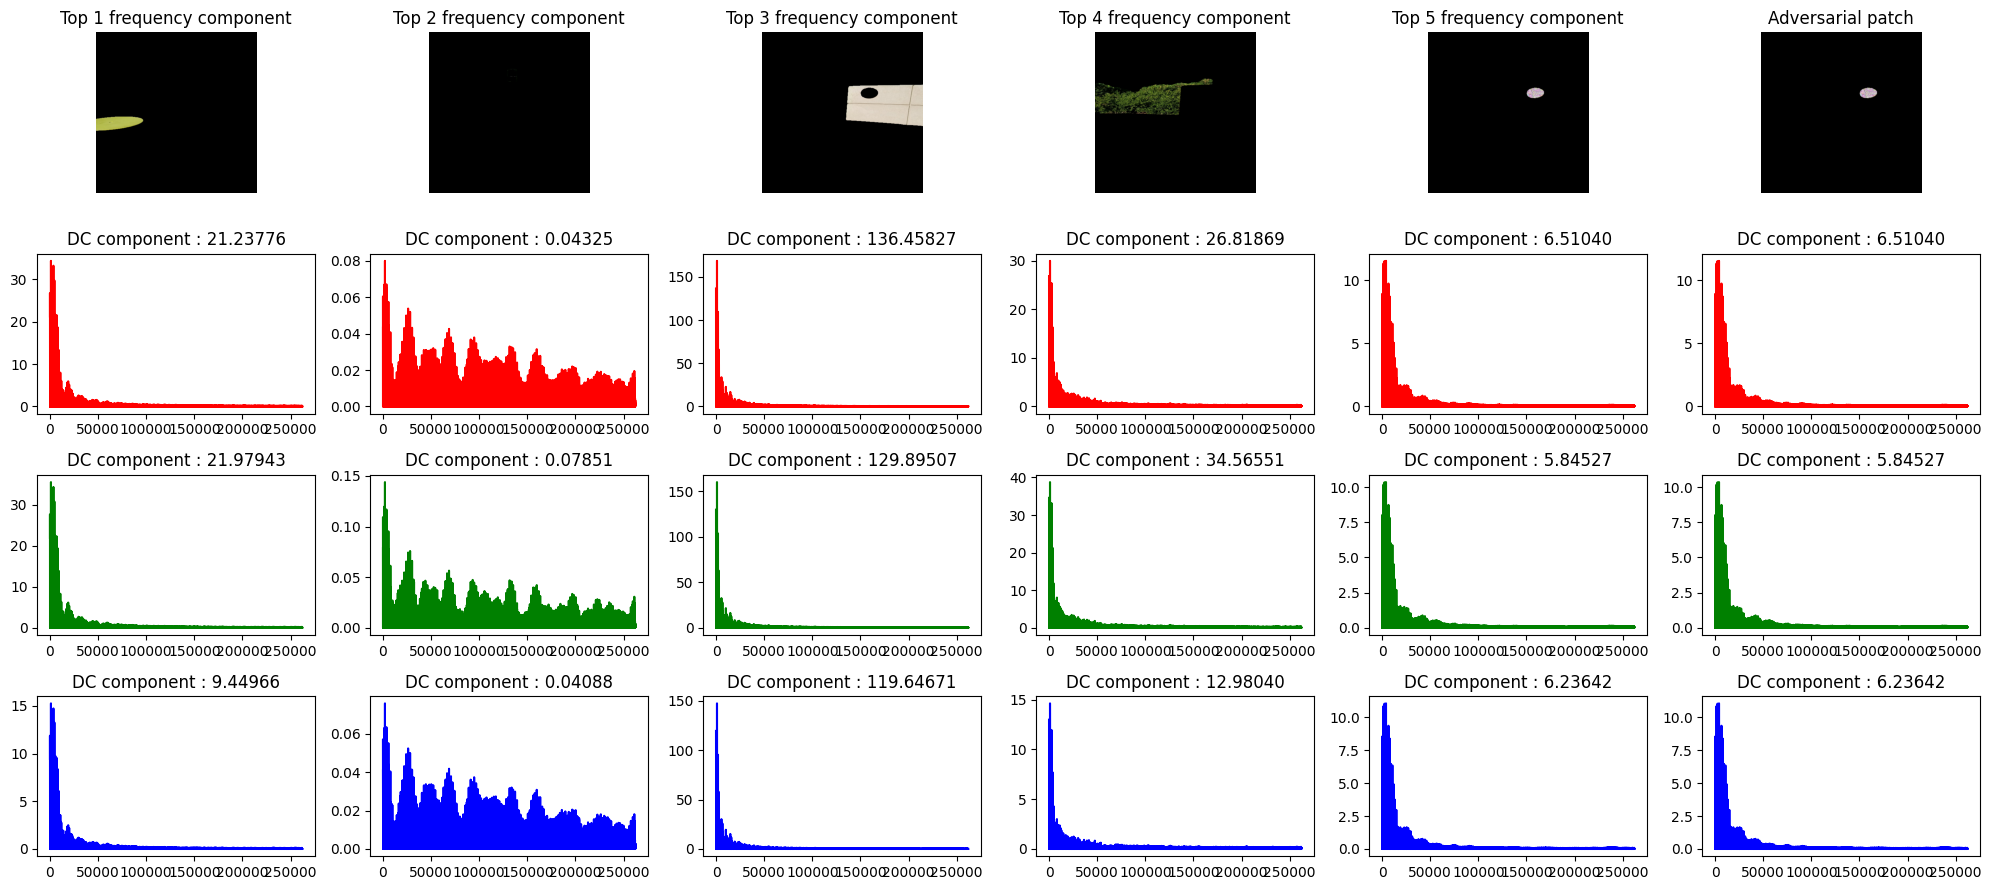

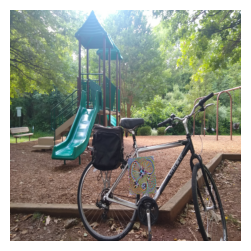

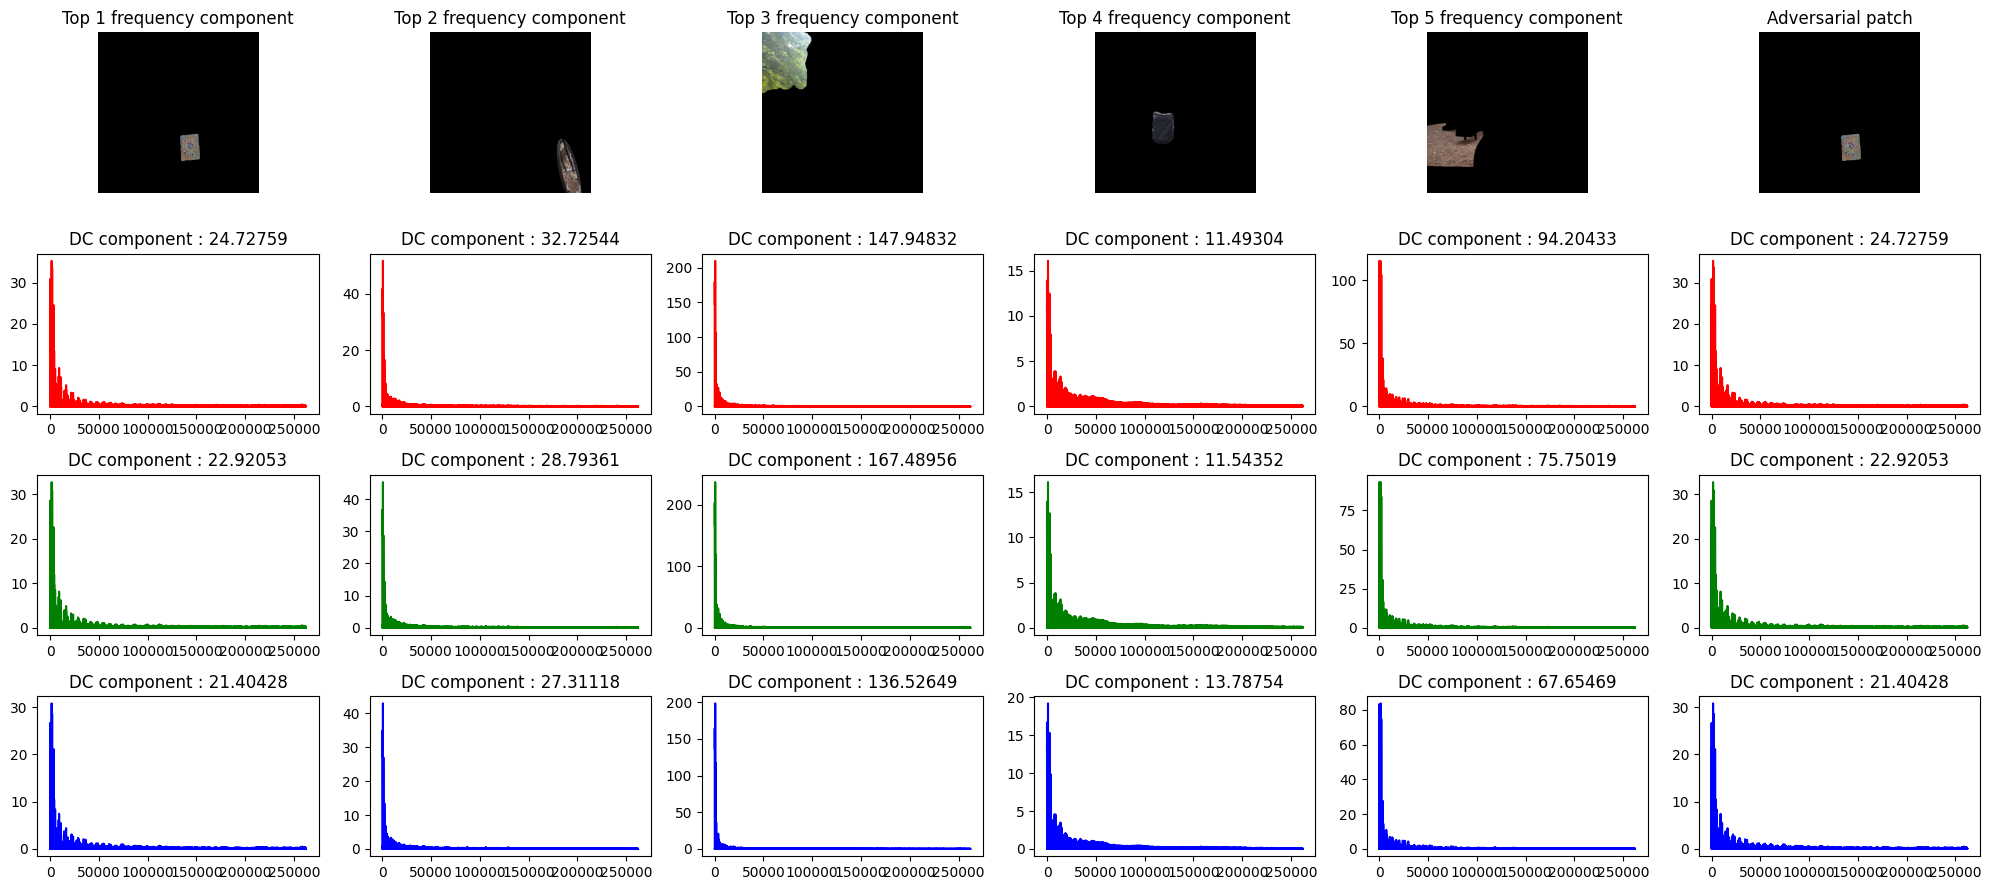

: 

In [6]:
num_images = 12
img_list, mask_list, random_numbers = getRandomImages(num_images)

patch_indices = []
num_top_images = 6

for i in range(num_images):
    masks = mask_generator.generate(img_list[i])
    all_masks = []
    for z, meta_info in enumerate(masks):
        all_masks.append(meta_info['segmentation'])

    iou_vals = compute_vectorized_iou(mask_list[i], all_masks)
    patch_mask_idx = np.argmax(iou_vals)

    # Count non-zero pixels in patch
    # patch_mask_count = np.sum(all_masks[patch_mask_idx] != 0)
    # print(patch_mask_count)

    max_frequencies_list = []
    dct_list = []
    masked_img_list = []

    dc_components = np.zeros((len(masks), 3))

    for j in range(len(masks)):
        current_mask = masks[j]['segmentation']

        # Count non-zero pixels in mask
        # current_mask_count = np.sum(current_mask != 0)
        # print(current_mask_count)
        # if current_mask_count >= patch_mask_count/2:

        mask_3d = np.repeat(current_mask[:, :, np.newaxis], 3, axis=2)
        masked_img = img_list[i] * mask_3d

        gray_scale = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

        magnitude_spectrum = scipy.fftpack.dct( scipy.fftpack.dct(masked_img, axis=0, norm='ortho' ), axis=1, norm='ortho' )
        
        # TODO Thresholding
        # magnitude_spectrum = magnitude_spectrum * (abs(magnitude_spectrum) > (0.012 * np.max(magnitude_spectrum)))

        magnitude_spectrum = np.abs(magnitude_spectrum)
        dct_list.append(magnitude_spectrum)
        masked_img_list.append(masked_img)
        
        # score = -np.sum(magnitude_spectrum > 5000) - np.sum(magnitude_spectrum < 1000)
        # score += np.count_nonzero((magnitude_spectrum >= 1000) & (magnitude_spectrum <= 5000))
        score = -j  # Dummy Score
        max_frequencies_list.append(score)

        # Not used
        dc_components[j][0] = magnitude_spectrum[0][0][0]
        dc_components[j][1] = magnitude_spectrum[0][0][1]
        dc_components[j][2] = magnitude_spectrum[0][0][2]
    

    dct_list = np.stack(dct_list, axis=-1)
    dc_components = 255.0 * (np.array(dc_components) - np.min(dct_list)) / (np.max(dct_list) - np.min(dct_list))
    # print(dc_components.shape)
    dct_list = 255.0 * (dct_list - np.min(dct_list)) / (np.max(dct_list) - np.min(dct_list))

    all_dc_components = dct_list[0,0,:,:]

    # Frequency for the patch mask
    patch_mask_freq = max_frequencies_list[patch_mask_idx]

    max_frequencies_list = np.array(max_frequencies_list)
    sorted_max_frequencies_list = np.sort(max_frequencies_list)[::-1]
    sorted_indices = np.argsort(max_frequencies_list)[::-1]

    # print(patch_mask_freq)
    # print(sorted_max_frequencies_list)

    patch_indices.append(np.where(sorted_max_frequencies_list == patch_mask_freq)[0][0])
    plt.figure(figsize=(4,3))
    plt.imshow(img_list[i])
    # plt.title('Original Image')
    plt.axis('off')
    plt.show()

    ###### Plot top 4 frequencies and the adversarial patch frequency (magnitude spectrum)
    fig, axes = plt.subplots(nrows=4, ncols=num_top_images, figsize=(20, 9))
    for k in range(num_top_images):
        # print("Image Index : {}, Mask Index : {}".format(random_numbers[i], k))
        if k != num_top_images - 1:
            axes[0][k].imshow(masked_img_list[k], cmap='gray')
            axes[0][k].set_title('Top {} frequency component'.format(k+1))
            axes[0][k].axis('off')

            axes[1][k].plot(dct_list[:,:,0,k].ravel(), label='red', color='red')
            axes[1][k].set_title('DC component : {:.5f}'.format(all_dc_components[0][k]))
            
            axes[2][k].plot(dct_list[:,:,1,k].ravel(), label='green', color='green')
            axes[2][k].set_title('DC component : {:.5f}'.format(all_dc_components[1][k]))

            axes[3][k].plot(dct_list[:,:,2,k].ravel(), label='blue', color='blue')
            axes[3][k].set_title('DC component : {:.5f}'.format(all_dc_components[2][k]))

        # Adversarial patch case
        else:
            axes[0][k].imshow(masked_img_list[patch_mask_idx], cmap='gray')
            axes[0][k].set_title('Adversarial patch')
            axes[0][k].axis('off')


            axes[1][k].plot(dct_list[:,:,0,patch_mask_idx].ravel(), label='red', color='red')
            axes[1][k].set_title('DC component : {:.5f}'.format(all_dc_components[0][patch_mask_idx]))
            
            axes[2][k].plot(dct_list[:,:,1,patch_mask_idx].ravel(), label='green', color='green')
            axes[2][k].set_title('DC component : {:.5f}'.format(all_dc_components[1][patch_mask_idx]))
            
            axes[3][k].plot(dct_list[:,:,2,patch_mask_idx].ravel(), label='blue', color='blue')
            axes[3][k].set_title('DC component : {:.5f}'.format(all_dc_components[2][patch_mask_idx]))

            # axes[1][k].imshow(dct_list[:,:,patch_mask_idx], cmap='hot', vmax=np.max(dct_list[:,:,patch_mask_idx]), vmin=np.min(dct_list[:,:,patch_mask_idx]))
            # axes[1][k].set_title('DCT')
            # axes[1][k].axis('off')
    
    plt.tight_layout()
    plt.show()
